In [2]:
# Preprocessing Functions
def trim_initial(df):
    return df[START_DELAY:]

def drop_zeroes(df):
    return df.loc[df.ax != 0.0]

def gen_rolling_window(df, pca=False):
    x_train = []
    y_train = []
    for uuid in df.uuid.unique():
        processed_df = df.loc[df.uuid == uuid]
        y_train_point = processed_df['exercise_type'].iloc[0]
        processed_df = trim_initial(processed_df)
        processed_df = drop_zeroes(processed_df)

        # Loop through to extract rolling window
        i = 0
        while i + WINDOW < len(processed_df):
            x_train_point = processed_df[i: i + WINDOW].filter(items=['ax', 'ay', 'az', 'gx', 'gy', 'gz'])
            if (pca):
                x_train_point = np.reshape(x_train_point.to_numpy(), -1)
                x_train.append(x_train_point)
            else:
                x_train.append(x_train_point.to_numpy())
            y_train.append(y_train_point)
            i = i + ROLLING_STEP
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    y_train = to_categorical(y_train)
    
    return x_train, y_train

In [3]:
# PCA Functions
import scipy.linalg as linalg
def ComputeNorm(x):
    # function r=ComputeNorm(x)
    # computes vector norms of x
    # x: d x m matrix, each column a vector
    # r: 1 x m matrix, each the corresponding norm (L2)

    [row, col] = x.shape
    r = np.zeros((1,col))

    for i in range(col):
        r[0,i] = linalg.norm(x[:,i])
    return r

def myLDA(A,Labels):
    # function [W,m]=myLDA(A,Label)
    # computes LDA of matrix A
    # A: D by N data matrix. Each column is a random vector
    # W: D by K matrix whose columns are the principal components in decreasing order
    # m: mean of each projection
    classLabels = np.unique(Labels)
    classNum = len(classLabels)
    dim,datanum = A.shape
    totalMean = np.mean(A,1)
    partition = [np.where(Labels==label)[0] for label in classLabels]
    classMean = [(np.mean(A[:,idx],1),len(idx)) for idx in partition]

    #compute the within-class scatter matrix
    W = np.zeros((dim,dim))
    for idx in partition:
        W += np.cov(A[:,idx],rowvar=1)*len(idx)

    #compute the between-class scatter matrix
    B = np.zeros((dim,dim))
    for mu,class_size in classMean:
        offset = mu - totalMean
        B += np.outer(offset,offset)*class_size

    #solve the generalized eigenvalue problem for discriminant directions
    ew, ev = linalg.eig(B, W)

    sorted_pairs = sorted(enumerate(ew), key=operator.itemgetter(1), reverse=True)
    selected_ind = [ind for ind,val in sorted_pairs[:classNum-1]]
    LDAW = ev[:,selected_ind]
    Centers = [np.dot(mu,LDAW) for mu,class_size in classMean]
    Centers = np.array(Centers).T
    return LDAW, Centers, classLabels

def myPCA(A):
    # function [W,LL,m]=mypca(A)
    # computes PCA of matrix A
    # A: D by N data matrix. Each column is a random vector
    # W: D by K matrix whose columns are the principal components in decreasing order
    # LL: eigenvalues
    # m: mean of columns of A

    # Note: "lambda" is a Python reserved word


    # compute mean, and subtract mean from every column
    [r,c] = A.shape
    m = np.mean(A,1)
    A = A - np.tile(m, (c,1)).T
    B = np.dot(A.T, A)
    [d,v] = linalg.eig(B)

    # sort d in descending order
    order_index = np.argsort(d)
    order_index =  order_index[::-1]
    d = d[order_index]
    v = v[:, order_index]

    # compute eigenvectors of scatter matrix
    W = np.dot(A,v)
    Wnorm = ComputeNorm(W)

    W1 = np.tile(Wnorm, (r, 1))
    W2 = W / W1
    
    LL = d[0:-1]

    W = W2[:,0:-1]      #omit last column, which is the nullspace
    
    return W, LL, m

def project_windows(windows, pcas, mean):
    # Each col in faces represents a face
    # Each col in pcas represents a pca
    # Each col in pca_features represents a feature
    # Transpose pca_features to before fitting into sci-kit model
    [rows, cols] = windows.shape #cols is no. of faces
    pca_features = pcas.T @ (windows - np.tile(mean, (cols, 1)).T)
    return pca_features

In [4]:
# Model Evaluation Functions
def evaluate_categorical_predictions(model, x_test, y_test):
    reference = {0: "Running", 1: "Push ups", 2: "Skipping"}
    right_predictions = {0:0, 1:0, 2:0}
    totals =  {0:0, 1:0, 2:0}
    predictions = model.predict(x_test)
    for i in range(len(predictions)):
        prediction = np.argmax(predictions[i])
        actual = np.argmax(y_test[i])
        print("Predicted: {} vs Actual: {}".format(reference[prediction], reference[actual]))
        totals[actual] += 1
        if prediction == actual:
            right_predictions[actual] += 1

    print("\n              ======================")
    print("Accuracy for Running: {.2f}%", 100*right_predictions[0]/totals[0])
    print("Accuracy for Push Ups: {.2f}%", 100*right_predictions[1]/totals[1])
    print("Accuracy for Skipping: {.2f}%", 100*right_predictions[2]/totals[2])
    
def get_prediction(model, sample):
    reference = {0: "Running", 1: "Push ups", 2: "Skipping"}
    predictions = x.predict(sample)
    return reference[np.argmax(predictions)]

In [5]:
# Imports
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential, metrics
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
import tensorflow.keras.optimizers as optimizers
import tensorflow as tf

In [6]:
# Global Variables
FILEPATH = "./data.csv"
START_DELAY = 16 #rows to remove to account for ramp up time
WINDOW = 33 # ~10s
ROLLING_STEP = 3 # ~1s

In [7]:
# Loading in the dataset
df = pd.read_csv(FILEPATH)
df

,sensorID,uuid,timecollected,ax,ay,az,gx,gy,gz,exercise_type
0,2,c1f7b71a-3f7d-11ec-90f0-dcfb48770d48,2021-11-07T03:51:04.491502Z,0.978027,1.346191,1.154297,-2.914429,-3.166199,1.579285,0
1,2,c1f7b71a-3f7d-11ec-90f0-dcfb48770d48,2021-11-07T03:51:04.190568Z,0.978027,1.346191,1.154297,-2.914429,-3.166199,1.579285,0
2,2,c1f7b71a-3f7d-11ec-90f0-dcfb48770d48,2021-11-07T03:51:03.888082Z,0.978027,1.346191,1.154297,-2.914429,-3.166199,1.579285,0
3,2,c1f7b71a-3f7d-11ec-90f0-dcfb48770d48,2021-11-07T03:51:03.578131Z,1.641113,1.117188,0.715820,11.596680,73.837280,-8.659363,0
4,2,c1f7b71a-3f7d-11ec-90f0-dcfb48770d48,2021-11-07T03:51:03.276226Z,1.641113,1.117188,0.715820,11.596680,73.837280,-8.659363,0
...,...,...,...,...,...,...,...,...,...,...
805,2,c9494b52-3bc4-11ec-8ca8-dcfb48770d48,2021-11-02T10:08:14.229519Z,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
806,2,c9494b52-3bc4-11ec-8ca8-dcfb48770d48,2021-11-02T10:08:13.914417Z,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
807,2,c9494b52-3bc4-11ec-8ca8-dcfb48770d48,2021-11-02T10:08:13.602219Z,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
808,2,c9494b52-3bc4-11ec-8ca8-dcfb48770d48,2021-11-02T10:08:13.289409Z,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1


In [7]:
# Processing the Dataset
X, Y = gen_rolling_window(df)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, 
                                                    random_state = 1)
print(len(x_train), len(x_test))

88 22


In [8]:
x_train.shape

(88, 33, 6)

## First we will observe how LSTM and MLP perform 

### LSTM

In [71]:
# Training Using LSTM
dropout = 0
epochs = 10
learning_rate = 0.00001
FEATURES = 6

lstm = Sequential()
lstm.add(LSTM(1024, activation='relu', input_shape=(WINDOW, FEATURES), return_sequences=False))
lstm.add(Dropout(dropout))
lstm.add(Dense(3, activation='softmax'))
# Create our optimizer
optimizer = optimizers.Adam(learning_rate = learning_rate)
lstm.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=[metrics.categorical_accuracy])

lstm.fit(x_train, y_train, epochs=epochs, verbose=1)
print('Calculating the Accuracy')
lstm.evaluate(x_test, y_test)

Epoch 1/10
3/3 [==============================] - 2s 440ms/step - loss: 8.4958 - categorical_accuracy: 0.2614
Epoch 2/10
3/3 [==============================] - 1s 456ms/step - loss: 7.6478 - categorical_accuracy: 0.2727
Epoch 3/10
3/3 [==============================] - 1s 443ms/step - loss: 6.4453 - categorical_accuracy: 0.3295
Epoch 4/10
3/3 [==============================] - 1s 453ms/step - loss: 4.7863 - categorical_accuracy: 0.3864
Epoch 5/10
3/3 [==============================] - 1s 458ms/step - loss: 3.9894 - categorical_accuracy: 0.4432
Epoch 6/10
3/3 [==============================] - 1s 439ms/step - loss: 4.2036 - categorical_accuracy: 0.4091
Epoch 7/10
3/3 [==============================] - 1s 453ms/step - loss: 4.0608 - categorical_accuracy: 0.4659
Epoch 8/10
3/3 [==============================] - 1s 438ms/step - loss: 4.3336 - categorical_accuracy: 0.4773
Epoch 9/10
3/3 [==============================] - 1s 446ms/step - loss: 4.8443 - categorical_accuracy: 0.5000
Epoch 10/1

[4.765928268432617, 0.3636363744735718]

In [65]:
evaluate_categorical_predictions(lstm, x_test, y_test)

Predicted: Running vs Actual: Push ups
Predicted: Push ups vs Actual: Running
Predicted: Push ups vs Actual: Skipping
Predicted: Running vs Actual: Push ups
Predicted: Skipping vs Actual: Skipping
Predicted: Skipping vs Actual: Push ups
Predicted: Skipping vs Actual: Push ups
Predicted: Skipping vs Actual: Skipping
Predicted: Skipping vs Actual: Running
Predicted: Running vs Actual: Running
Predicted: Skipping vs Actual: Skipping
Predicted: Running vs Actual: Push ups
Predicted: Skipping vs Actual: Running
Predicted: Running vs Actual: Push ups
Predicted: Skipping vs Actual: Push ups
Predicted: Push ups vs Actual: Running
Predicted: Skipping vs Actual: Push ups

Accuracy for Running: {.2f}% 20.0
Accuracy for Push Ups: {.2f}% 0.0
Accuracy for Skipping: {.2f}% 75.0


### MLP

In [294]:
# Processing the Dataset
X, Y = gen_rolling_window(df)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.15, 
                                                    random_state = 1)

In [301]:
y_train.shape

(93, 3)

In [302]:
lr = 0.0001
momentum = 0.1
decay = 0.02
epochs = 25

mlp = Sequential()
mlp.add(Dense(1024, input_shape = (33, 6), activation = 'relu'))
mlp.add(Dense(3, activation = 'softmax'))
optimizer = optimizers.Adam(learning_rate=lr, decay=decay)

mlp.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics='accuracy')

mlp.fit(x_train, y_train, epochs=epochs, verbose=1)
print('Calculating the Accuracy')
#mlp.evaluate(x_test, y_test)

Epoch 1/25


ValueError: in user code:

    c:\users\mudaafi\desktop\nus\cs3237 - iot\venv\lib\site-packages\keras\engine\training.py:853 train_function  *
        return step_function(self, iterator)
    c:\users\mudaafi\desktop\nus\cs3237 - iot\venv\lib\site-packages\keras\engine\training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    c:\users\mudaafi\desktop\nus\cs3237 - iot\venv\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    c:\users\mudaafi\desktop\nus\cs3237 - iot\venv\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    c:\users\mudaafi\desktop\nus\cs3237 - iot\venv\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    c:\users\mudaafi\desktop\nus\cs3237 - iot\venv\lib\site-packages\keras\engine\training.py:835 run_step  **
        outputs = model.train_step(data)
    c:\users\mudaafi\desktop\nus\cs3237 - iot\venv\lib\site-packages\keras\engine\training.py:789 train_step
        y, y_pred, sample_weight, regularization_losses=self.losses)
    c:\users\mudaafi\desktop\nus\cs3237 - iot\venv\lib\site-packages\keras\engine\compile_utils.py:201 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    c:\users\mudaafi\desktop\nus\cs3237 - iot\venv\lib\site-packages\keras\losses.py:141 __call__
        losses = call_fn(y_true, y_pred)
    c:\users\mudaafi\desktop\nus\cs3237 - iot\venv\lib\site-packages\keras\losses.py:245 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    c:\users\mudaafi\desktop\nus\cs3237 - iot\venv\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    c:\users\mudaafi\desktop\nus\cs3237 - iot\venv\lib\site-packages\keras\losses.py:1666 categorical_crossentropy
        y_true, y_pred, from_logits=from_logits, axis=axis)
    c:\users\mudaafi\desktop\nus\cs3237 - iot\venv\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    c:\users\mudaafi\desktop\nus\cs3237 - iot\venv\lib\site-packages\keras\backend.py:4839 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    c:\users\mudaafi\desktop\nus\cs3237 - iot\venv\lib\site-packages\tensorflow\python\framework\tensor_shape.py:1161 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 3) and (None, 33, 3) are incompatible


In [ ]:
evaluate_categorical_predictions(mlp, x_test, y_test)

## We will now attempt to train using Principal Component Analysis (PCA) and compare the results

In [185]:
# Processing the Dataset
X, Y = gen_rolling_window(df, pca=True)
pcas, eigenvalues, mean = myPCA(X.T)

# retain only 30 eigenfaces/pcas
D = 30
pcas = pcas[:, :D]

pca_features = project_windows(X.T, pcas, mean)
x_train, x_test, y_train, y_test = train_test_split(pca_features.T, Y, test_size = 0.2, random_state=1)

In [137]:
# Save the pca file for future use

import pickle
with open("meanv2.txt", "wb") as mean_file:
    pickle.dump(mean, mean_file)
    
with open("pcasv2.txt", "wb") as pcas_file:
    pickle.dump(pcas, pcas_file)

In [187]:
FEATURES = pca_features.shape
FEATURES

(30, 110)

In [254]:
FEATURES = pca_features.shape
learning_rate = 0.000001
momentum = 0.01
decay = 0.02
epochs = 150

pca_mlp = Sequential(name="PCA_MLP")
pca_mlp.add(Dense(1024, input_shape = (30, ), activation = 'relu'))
pca_mlp.add(Dense(512, activation = 'relu'))
pca_mlp.add(Dense(512, activation = 'relu'))
pca_mlp.add(Dense(3, activation = 'softmax'))
optimizer = optimizers.Adam(learning_rate=learning_rate, decay=decay)

pca_mlp.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics='accuracy')

pca_mlp.fit(x_train, y_train, epochs=epochs, verbose=1)
print('Calculating the Accuracy')
pca_mlp.evaluate(x_test, y_test)

Epoch 1/150
3/3 [==============================] - 0s 6ms/step - loss: 11.1854 - accuracy: 0.4545
Epoch 2/150
3/3 [==============================] - 0s 8ms/step - loss: 10.9880 - accuracy: 0.4545
Epoch 3/150
3/3 [==============================] - 0s 7ms/step - loss: 10.7989 - accuracy: 0.4545
Epoch 4/150
3/3 [==============================] - 0s 8ms/step - loss: 10.6551 - accuracy: 0.4545
Epoch 5/150
3/3 [==============================] - 0s 7ms/step - loss: 10.5095 - accuracy: 0.4773
Epoch 6/150
3/3 [==============================] - 0s 7ms/step - loss: 10.3887 - accuracy: 0.4773
Epoch 7/150
3/3 [==============================] - 0s 7ms/step - loss: 10.2584 - accuracy: 0.4773
Epoch 8/150
3/3 [==============================] - 0s 7ms/step - loss: 10.1337 - accuracy: 0.4773
Epoch 9/150
3/3 [==============================] - 0s 7ms/step - loss: 10.0248 - accuracy: 0.5000
Epoch 10/150
3/3 [==============================] - 0s 6ms/step - loss: 9.9259 - accuracy: 0.5000
Epoch 11/150
3/3 [==

[14.453357696533203, 0.22727273404598236]

In [179]:
pca_mlp.save('modelv2.b')

INFO:tensorflow:Assets written to: modelv2.b\assets


In [142]:
evaluate_categorical_predictions(pca_mlp, x_test, y_test)

print("\n          =================== \n")
count = [0, 0, 0]
for y in Y:
    count[np.argmax(y)] += 1

print("Running dataset: {}", count[0])
print("Push-Ups dataset: {}", count[1])
print("Skipping dataset: {}", count[2])


Predicted: Push ups vs Actual: Push ups
Predicted: Running vs Actual: Running
Predicted: Running vs Actual: Skipping
Predicted: Push ups vs Actual: Push ups
Predicted: Skipping vs Actual: Skipping
Predicted: Push ups vs Actual: Push ups
Predicted: Push ups vs Actual: Push ups
Predicted: Skipping vs Actual: Skipping
Predicted: Running vs Actual: Running
Predicted: Running vs Actual: Running
Predicted: Skipping vs Actual: Skipping

Accuracy for Running: {.2f}% 100.0
Accuracy for Push Ups: {.2f}% 100.0
Accuracy for Skipping: {.2f}% 75.0


Running dataset: {} 54
Push-Ups dataset: {} 30
Skipping dataset: {} 26


## CNN

In [9]:
# Processing the Dataset
X, Y = gen_rolling_window(df)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.15, 
                                                    random_state = 1)

In [10]:
x_train.shape

(93, 33, 6)

In [11]:
x_train[0]

array([[ 1.99707031e-01,  2.08544922e+00,  2.25097656e-01,
         1.11480713e+02,  1.40991211e+01, -4.88204956e+01],
       [ 1.99707031e-01,  2.08544922e+00,  2.25097656e-01,
         1.11480713e+02,  1.40991211e+01, -4.88204956e+01],
       [ 1.99707031e-01,  2.08544922e+00,  2.25097656e-01,
         1.11480713e+02,  1.40991211e+01, -4.88204956e+01],
       [-4.15527344e-01,  1.76367188e+00,  9.38476562e-01,
         4.87136841e+01,  1.42288208e+01, -3.34930420e+01],
       [-4.15527344e-01,  1.76367188e+00,  9.38476562e-01,
         4.87136841e+01,  1.42288208e+01, -3.34930420e+01],
       [-4.15527344e-01,  1.76367188e+00,  9.38476562e-01,
         4.87136841e+01,  1.42288208e+01, -3.34930420e+01],
       [-2.26562500e-01,  1.99951172e+00,  2.11425781e-01,
        -1.05972290e+01,  2.93731689e+00,  1.31988525e+00],
       [-2.26562500e-01,  1.99951172e+00,  2.11425781e-01,
        -1.05972290e+01,  2.93731689e+00,  1.31988525e+00],
       [-2.26562500e-01,  1.99951172e+00,  2.114

In [12]:
def make_model():
    input_layer = tf.keras.layers.Input((33,6))

    conv1 = tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = tf.keras.layers.BatchNormalization()(conv1)
    conv1 = tf.keras.layers.ReLU()(conv1)

    conv2 = tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = tf.keras.layers.BatchNormalization()(conv2)
    conv2 = tf.keras.layers.ReLU()(conv2)

    conv3 = tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = tf.keras.layers.BatchNormalization()(conv3)
    conv3 = tf.keras.layers.ReLU()(conv3)
    
    dense1 = Dense(1024, activation = 'relu')(conv3)

    gap = tf.keras.layers.GlobalAveragePooling1D()(dense1)

    output_layer = tf.keras.layers.Dense(3, activation="softmax")(gap)

    return tf.keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model()
plot_model(model, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [13]:
epochs = 300
batch_size = 64

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "cnn_model", save_best_only=True, monitor="val_loss"
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=7, min_lr=0.0001
    ),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["categorical_accuracy"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/300
2/2 [==============================] - 1s 213ms/step - loss: 1.1234 - categorical_accuracy: 0.1351 - val_loss: 0.7728 - val_categorical_accuracy: 0.3684
INFO:tensorflow:Assets written to: cnn_model\assets
Epoch 2/300
2/2 [==============================] - 0s 37ms/step - loss: 0.8051 - categorical_accuracy: 0.7027 - val_loss: 1.2753 - val_categorical_accuracy: 0.3158
Epoch 3/300
2/2 [==============================] - 0s 37ms/step - loss: 0.6715 - categorical_accuracy: 0.6892 - val_loss: 1.5323 - val_categorical_accuracy: 0.3158
Epoch 4/300
2/2 [==============================] - 0s 34ms/step - loss: 0.4897 - categorical_accuracy: 0.9459 - val_loss: 1.2033 - val_categorical_accuracy: 0.3158
Epoch 5/300
2/2 [==============================] - 0s 40ms/step - loss: 0.3999 - categorical_accuracy: 0.9324 - val_loss: 1.1283 - val_categorical_accuracy: 0.3158
Epoch 6/300
2/2 [==============================] - 0s 33ms/step - loss: 0.3206 - categorical_accuracy: 0.9459 - val_loss: 1.174

Epoch 45/300
2/2 [==============================] - 0s 41ms/step - loss: 0.0050 - categorical_accuracy: 1.0000 - val_loss: 0.0860 - val_categorical_accuracy: 1.0000
INFO:tensorflow:Assets written to: cnn_model\assets
Epoch 46/300
2/2 [==============================] - 0s 38ms/step - loss: 0.0042 - categorical_accuracy: 1.0000 - val_loss: 0.0801 - val_categorical_accuracy: 1.0000
INFO:tensorflow:Assets written to: cnn_model\assets
Epoch 47/300
2/2 [==============================] - 0s 40ms/step - loss: 0.0039 - categorical_accuracy: 1.0000 - val_loss: 0.0744 - val_categorical_accuracy: 1.0000
INFO:tensorflow:Assets written to: cnn_model\assets
Epoch 48/300
2/2 [==============================] - 0s 35ms/step - loss: 0.0053 - categorical_accuracy: 1.0000 - val_loss: 0.0683 - val_categorical_accuracy: 1.0000
INFO:tensorflow:Assets written to: cnn_model\assets
Epoch 49/300
2/2 [==============================] - 0s 37ms/step - loss: 0.0040 - categorical_accuracy: 1.0000 - val_loss: 0.0629 - 

Epoch 88/300
2/2 [==============================] - 0s 31ms/step - loss: 0.0028 - categorical_accuracy: 1.0000 - val_loss: 0.0203 - val_categorical_accuracy: 1.0000
Epoch 89/300
2/2 [==============================] - 0s 29ms/step - loss: 0.0028 - categorical_accuracy: 1.0000 - val_loss: 0.0174 - val_categorical_accuracy: 1.0000
Epoch 90/300
2/2 [==============================] - 0s 32ms/step - loss: 0.0038 - categorical_accuracy: 1.0000 - val_loss: 0.0144 - val_categorical_accuracy: 1.0000
INFO:tensorflow:Assets written to: cnn_model\assets
Epoch 91/300
2/2 [==============================] - 0s 36ms/step - loss: 0.0025 - categorical_accuracy: 1.0000 - val_loss: 0.0124 - val_categorical_accuracy: 1.0000
INFO:tensorflow:Assets written to: cnn_model\assets
Epoch 92/300
2/2 [==============================] - 0s 38ms/step - loss: 0.0053 - categorical_accuracy: 1.0000 - val_loss: 0.0111 - val_categorical_accuracy: 1.0000
INFO:tensorflow:Assets written to: cnn_model\assets
Epoch 93/300
2/2 [=

2/2 [==============================] - 0s 48ms/step - loss: 0.0010 - categorical_accuracy: 1.0000 - val_loss: 0.0021 - val_categorical_accuracy: 1.0000
Epoch 129/300
2/2 [==============================] - 0s 37ms/step - loss: 0.0040 - categorical_accuracy: 1.0000 - val_loss: 0.0020 - val_categorical_accuracy: 1.0000
Epoch 130/300
2/2 [==============================] - 0s 36ms/step - loss: 0.0014 - categorical_accuracy: 1.0000 - val_loss: 0.0018 - val_categorical_accuracy: 1.0000
Epoch 131/300
2/2 [==============================] - 0s 34ms/step - loss: 0.0010 - categorical_accuracy: 1.0000 - val_loss: 0.0017 - val_categorical_accuracy: 1.0000
Epoch 132/300
2/2 [==============================] - 0s 36ms/step - loss: 0.0012 - categorical_accuracy: 1.0000 - val_loss: 0.0016 - val_categorical_accuracy: 1.0000
Epoch 133/300
2/2 [==============================] - 0s 33ms/step - loss: 0.0045 - categorical_accuracy: 1.0000 - val_loss: 0.0014 - val_categorical_accuracy: 1.0000
Epoch 134/300
2/2 

INFO:tensorflow:Assets written to: cnn_model\assets
Epoch 168/300
2/2 [==============================] - 0s 39ms/step - loss: 0.0019 - categorical_accuracy: 1.0000 - val_loss: 5.0398e-04 - val_categorical_accuracy: 1.0000
INFO:tensorflow:Assets written to: cnn_model\assets
Epoch 169/300
2/2 [==============================] - 0s 37ms/step - loss: 4.2819e-04 - categorical_accuracy: 1.0000 - val_loss: 4.9535e-04 - val_categorical_accuracy: 1.0000
INFO:tensorflow:Assets written to: cnn_model\assets
Epoch 170/300
2/2 [==============================] - 0s 37ms/step - loss: 6.9243e-04 - categorical_accuracy: 1.0000 - val_loss: 4.8881e-04 - val_categorical_accuracy: 1.0000
INFO:tensorflow:Assets written to: cnn_model\assets
Epoch 171/300
2/2 [==============================] - 0s 39ms/step - loss: 7.0851e-04 - categorical_accuracy: 1.0000 - val_loss: 4.8568e-04 - val_categorical_accuracy: 1.0000
INFO:tensorflow:Assets written to: cnn_model\assets
Epoch 172/300
2/2 [=============================

2/2 [==============================] - 0s 42ms/step - loss: 2.8544e-04 - categorical_accuracy: 1.0000 - val_loss: 2.5794e-04 - val_categorical_accuracy: 1.0000
INFO:tensorflow:Assets written to: cnn_model\assets
Epoch 247/300
2/2 [==============================] - 0s 40ms/step - loss: 3.0071e-04 - categorical_accuracy: 1.0000 - val_loss: 2.5515e-04 - val_categorical_accuracy: 1.0000
INFO:tensorflow:Assets written to: cnn_model\assets
Epoch 248/300
2/2 [==============================] - 0s 41ms/step - loss: 2.6826e-04 - categorical_accuracy: 1.0000 - val_loss: 2.5313e-04 - val_categorical_accuracy: 1.0000
INFO:tensorflow:Assets written to: cnn_model\assets
Epoch 249/300
2/2 [==============================] - 0s 35ms/step - loss: 3.1784e-04 - categorical_accuracy: 1.0000 - val_loss: 2.5078e-04 - val_categorical_accuracy: 1.0000
INFO:tensorflow:Assets written to: cnn_model\assets
Epoch 250/300
2/2 [==============================] - 0s 40ms/step - loss: 3.3592e-04 - categorical_accuracy: 1

Epoch 286/300
2/2 [==============================] - 0s 32ms/step - loss: 2.9309e-04 - categorical_accuracy: 1.0000 - val_loss: 2.5437e-04 - val_categorical_accuracy: 1.0000
Epoch 287/300
2/2 [==============================] - 0s 32ms/step - loss: 6.7598e-04 - categorical_accuracy: 1.0000 - val_loss: 2.5319e-04 - val_categorical_accuracy: 1.0000
Epoch 288/300
2/2 [==============================] - 0s 32ms/step - loss: 3.5219e-04 - categorical_accuracy: 1.0000 - val_loss: 2.5225e-04 - val_categorical_accuracy: 1.0000
Epoch 289/300
2/2 [==============================] - 0s 31ms/step - loss: 2.2809e-04 - categorical_accuracy: 1.0000 - val_loss: 2.5146e-04 - val_categorical_accuracy: 1.0000
Epoch 290/300
2/2 [==============================] - 0s 32ms/step - loss: 2.2767e-04 - categorical_accuracy: 1.0000 - val_loss: 2.5155e-04 - val_categorical_accuracy: 1.0000
Epoch 291/300
2/2 [==============================] - 0s 34ms/step - loss: 2.2830e-04 - categorical_accuracy: 1.0000 - val_loss: 2.

In [14]:
test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

1/1 [==============================] - 0s 23ms/step - loss: 6.0452e-04 - categorical_accuracy: 1.0000
Test accuracy 1.0
Test loss 0.000604515487793833


In [27]:
#modelx = tf.keras.models.load_model("./cnn_model")

1/1 [==============================] - 0s 201ms/step - loss: 6.9370e-04 - categorical_accuracy: 1.0000


[0.0006936962599866092, 1.0]

In [24]:
history.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])

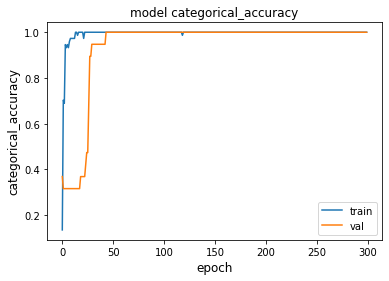

In [25]:
metric = "categorical_accuracy"
import matplotlib.pyplot as plt
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()


In [26]:
evaluate_categorical_predictions(model, x_test, y_test)

Exception ignored in: <function ScopedTFGraph.__del__ at 0x00000182AA7E5948>
Traceback (most recent call last):
  File "c:\users\mudaafi\desktop\nus\cs3237 - iot\venv\lib\site-packages\tensorflow\python\framework\c_api_util.py", line 58, in __del__
    self.deleter(self.graph)
AttributeError: deleter


Predicted: Push ups vs Actual: Push ups
Predicted: Running vs Actual: Running
Predicted: Skipping vs Actual: Skipping
Predicted: Push ups vs Actual: Push ups
Predicted: Skipping vs Actual: Skipping
Predicted: Push ups vs Actual: Push ups
Predicted: Push ups vs Actual: Push ups
Predicted: Skipping vs Actual: Skipping
Predicted: Running vs Actual: Running
Predicted: Running vs Actual: Running
Predicted: Skipping vs Actual: Skipping
Predicted: Push ups vs Actual: Push ups
Predicted: Running vs Actual: Running
Predicted: Push ups vs Actual: Push ups
Predicted: Push ups vs Actual: Push ups
Predicted: Running vs Actual: Running
Predicted: Push ups vs Actual: Push ups

Accuracy for Running: {.2f}% 100.0
Accuracy for Push Ups: {.2f}% 100.0
Accuracy for Skipping: {.2f}% 100.0
